*Alexander Rush @harvardnlp*

<a href="https://colab.research.google.com/github/harvardnlp/namedtensor/blob/master/notebooks/NamedTensor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*TL;DR: The previous post [Tensor Considered Harmful](http://nlp.seas.harvard.edu/NamedTensor) called for using **named tensors** to remedy some of the issues with the ubiquitous Tensor object. The post sparked significant conversation about whether this was a useful technique or would simply litter code unnecessary annotations. This follow-up considers the use of named tensors in real-world deep learning code. This post takes a more pragmatic tack, and examines two methods for integrating named tensors into the current deep learning ecosystem. As before all the code is available in the **PyTorch library** accompanying this blog post is available as [namedtensor](https://github.com/harvardnlp/NamedTensor)* which has been significantly changed based on ideas from [twitter](https://twitter.com/harvardnlp/status/1080911225427496966) / [reddit](https://www.reddit.com/r/MachineLearning/comments/accmek/d_tensor_considered_harmful_a_polemic_against/) comments.*


* Table of Contents                                                                                                                                                                                             
{:toc}

# Named Tensors for Deep Learning

The previous post  [Tensor Considered Harmful](http://nlp.seas.harvard.edu/NamedTensor) proposes that many of the core usability issues in deep learning frameworks come from manipulating and aligning tensor objects. It shows this by playing aroung with some toy tensor examples.

However, in hindsight, this was cheating. To actually use *named tensors* we need to interact with the ecosystem at large. The entire of richness of PyTorch is its libraries, which like it or not, are written with a tuple-based calling convention. If we want to write real software in real environments, it is not sufficient to simply show that naming is useful, it has be usable with the current functionality. 

**The Challenge**: How can we *lift* deep learning systems in a pragmatic manner so that they preserve the the semantics of *named tensors*?

I do not have the correct answer to this question. But in this post, I will consider two methods: explicit annotations and lifting the library. 



In [0]:
#@title Setup
!rm -fr NamedTensor/; git clone -q https://github.com/harvardnlp/NamedTensor.git
!cd NamedTensor; pip install -q .; pip install -q torch numpy opt_einsum
!cp NamedTensor/notebooks/test* . 


In [0]:
import numpy 
import torch
import torch.nn as nn
import torch.nn.functional as F
from namedtensor import NamedTensor, ntorch
from namedtensor import _im_init
_im_init()

## Method 1: Name Annotations

In PyTorch, the standard deep learning library lives in the `nn` module. This library contains bindings to all the useful functions that make up neural networks. To use them we pass around and manipulate tensor objects. Here are two mini modules:

In [3]:
relu = nn.ReLU()
linear = nn.Linear(3, 1)
linear 

Linear(in_features=3, out_features=1, bias=True)

The API for these modules is specified through the shape of the tensors passed. For instance for "relu" we see that this keeps the size the same as the original. 


In [4]:
print("\n".join(relu.__doc__.split("\n")[:13]))

Applies the rectified linear unit function element-wise
    :math:`\text{ReLU}(x)= \max(0, x)`

    .. image:: scripts/activation_images/ReLU.png

    Args:
        inplace: can optionally do the operation in-place. Default: ``False``

    Shape:
        - Input: :math:`(N, *)` where `*` means, any number of additional
          dimensions
        - Output: :math:`(N, *)`, same shape as the input



On the other hand if we look at the linear object we can see that it takes as input something of the form "(N, \*, in_features)" and outputs something of the form  "(N, \*, out_features)"

In [5]:
print("\n".join(linear.__doc__.split("\n")[:14]))

Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, \text{in\_features})` where :math:`*` means any number of
          additional dimensions
        - Output: :math:`(N, *, \text{out\_features})` where all but the last dimension
          are the same shape as the input.



This gives a rough sense of the API. Now let's try this out with our images. 

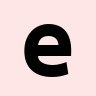

In [6]:
ims = torch.tensor(numpy.load('test_images.npy'), requires_grad=False).float()
ims = NamedTensor(ims, ("b", "h", "w", "c"))
first = ims.get("b", 0)
first

The standard non-named way is to call these directly.

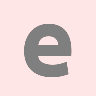

In [7]:
relu(first.values.sub(0.5)).add(0.5)

Our approach is going to instead explicitly chain the operation through the `op` method. This method takes in an function that acts on the raw tensor. 

In this case of relu, it is pretty boring it just applies the function directly. 

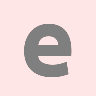

In [8]:
first.sub(0.5).op(lambda x: relu(x)).add(0.5)

# or 

first.sub(0.5).op(relu).add(0.5)

Things get more interesting when we apply `linear`. This operation changes the size of the last dimension. If we try to do this we get an error. To do it right, we need to supply a new name.

In [9]:
try:
    first.op(linear)
except AssertionError:
    print("Failed to apply linear op.")

Failed to apply linear op.


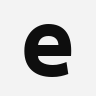

In [14]:
first.op(linear, c2="c").get("c2", 0)

I say this approach is pragmatic, because it still requires us to give the correct ordering to all the pytorch modules, and to give new names. This can be a bit annoying, but I would argue it makes for more readable and safer code. 

For instance if we look at the shape of the Conv2d module we see that it expects channel first and changes three dimensions.   

In [26]:
conv = nn.Conv2d(3, 3, 2)
print("\n".join(conv.__doc__.split("\n")[75:85]))

    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{out}, H_{out}, W_{out})` where

          .. math::
              H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor

          .. math::
              W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]


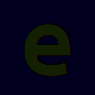

In [32]:
ims.transpose("c", "h", "w").op(conv, c2="c", h2="h", w2="w") \
   .get("b", 0).transpose("h2", "w2", "c2")

The `op` method is the core extension for interacting with "unsafe", unnamed PyTorch. We also consider two related methods. The method `reduce` wraps operations that drop a dimension, and the method `augment` wraps operations that add a new dimension. 

In [50]:
loss = nn.NLLLoss(reduce=False)
output = ntorch.randn(dict(batch=10, classes=20)).softmax("classes")
targets = ntorch.ones(dict(batch= 10)).long()
l = lambda x: loss(x, targets.values)
output.reduce(l, ("classes")).shape

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


OrderedDict([('batch', 10)])

In [35]:
embedding = nn.Embedding(10, 20)
x = ntorch.ones(dict(batch= 10, slen=20)).long()
x.augment(embedding, "embeddingsize").shape

OrderedDict([('batch', 10), ('slen', 20), ('embeddingsize', 20)])

These methods are really just syntactic sugar on top of the `op` method above, but they make it a bit easier to tell what is happening when you read the code.  

## Method 2: Named Everything

The above approach is relatively general. We want to use the pytorch library so we need to type it on input and output so that we can maintain our labels. Ideally though we can know exactly the names of the dimensions that are being used so that we can propagate them through.

Interestingly the PyTorch distributions library is written in such a way to make this possible, so it is fun to see what it looks like as a named library. 

In [0]:
import torch.distributions as distributions
import seaborn
import matplotlib.pyplot as plt
from namedtensor import ndistributions 

First let's make some parameters for a multivariate normal. and make a distribution.

In [0]:
mu = torch.randn(10, 2)
Sigma = torch.zeros(10, 2, 2)
Sigma[:] = torch.tensor([[1., 0], [0, 1.]])

In [0]:
dist = distributions.MultivariateNormal(mu, Sigma)

Okay, so what happened here? We made a distribution object that has a bunch of different distributions all combined together. This object has two important properties, its batch shape and its event shape. In particular this is a batch of 10 distributions each over with 2D outputs.  

In [79]:
dist.batch_shape, dist.event_shape

(torch.Size([10]), torch.Size([2]))

Now let's say we want to sample from all of these distributions simultaneously. We can do that with this call.

In [82]:
samples = dist.sample(torch.Size([20, 30]))
samples.shape

torch.Size([20, 30, 10, 2])

So now we have an object that is 20x30 samples of a 10 batches each of dim 2. This is nice to have, but we have to keep track of events, batches, samples... It gets hard fast.


Let's rewind and try it in named world now.

In [0]:
mu = ntorch.randn(dict(dist=10, out=2)).mul(5)
Sigma = ntorch.zeros(dict(batch=10, a=2, b=2))
Sigma.values[:] = torch.tensor([[1., 0], [0, 1.]])

In [0]:
dist = ndistributions.MultivariateNormal(mu, Sigma)

We've overridden the shape calls to give us named output now and sample takes in a dict. Should be a bit more clear. 

In [107]:
dist.batch_shape, dist.event_shape

(OrderedDict([('dist', 10)]), OrderedDict([('out', 2)]))

In [108]:
samples = dist.sample(sample1=20, sample2=30)
samples.shape

OrderedDict([('sample1', 20), ('sample2', 30), ('dist', 10), ('out', 2)])

Everything is the same as before, except that the distribution propagates our dimension labels through to the end. This really comes in handy when you want to do some plots. Here was enumerate over the samples from each distribution and plot the samples. 

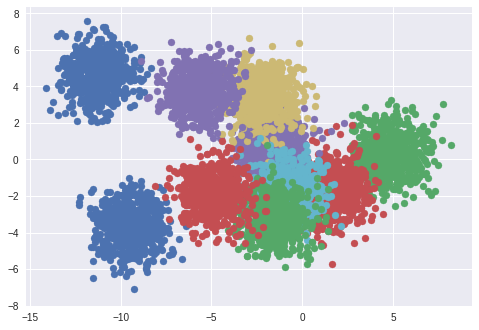

In [110]:
for i in range(10):
    b = samples.get("dist", i)
    plt.scatter(x=b.get("out", 0).values.numpy(),
                y=b.get("out", 1).values.numpy())

# Experiments on Canonical Models

Now the question is whether this approach can actually be applied to real deep learning problems. To test this, I went through several of the key deep learning mini-models to see what the code looks like. Honestly, I am not sure I am completely convinced... it looks like a start, but maybe not completely there. 

## MNist

The first example comes from a simple MNist network that is shipped with PyTorch. The full original example is available at [MNist example](https://github.com/pytorch/examples/blob/master/mnist/main.py) and our named example is available [named MNist example](https://github.com/harvardnlp/namedtensor/blob/master/examples/mnist.py). Here we compare two variants, one with standard tensor and the other with named tensor. 

<img src="http://deeplearning.net/tutorial/_images/mylenet.png">

In [0]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

The standard implementation is here. The code is pretty clean, it is a straight line of applying modules one after the other. The dimensions mostly line up along the way, but perhaps that was decided because this is the most standard example.

In [0]:
class StandardCNN(BaseNet):
    def forward(self, x):
        # batch x c x h x w
        x = F.relu(self.conv1(x))
        # batch x c1 x h1 x w1
        x = F.max_pool2d(x, 2, 2)
        # batch x c1 x h1a x w1a
        x = F.relu(self.conv2(x))
        # batch x c2 x h2 x w2
        x = F.max_pool2d(x, 2, 2)
        # batch x c2a x h2a x w2a
        x = x.view(-1, 4*4*50)
        # batch x fc1
        x = F.relu(self.fc1(x))
        # batch x fc2
        x = self.fc2(x)
        # batch x classes
        return F.log_softmax(x, dim=1)

Next consider the named version. The code is not necessarily more concise. However it does have some useful differences. Notably

*  The `op` will check that changed dimensions get updated along the way, so it is harder to screw up transposes. 

* Names are in the code, so debugging gives better errors. Furthermore we can add checks like the `assert_size`.

* The transpose, view and softmax become nicer in the process. 


In [0]:
class NamedNet(nn.Module):
    def forward(self, x):
        pool = lambda x: F.max_pool2d(x, 2, 2)

        return (
            x.transpose("c", "h", "w")
            .op(self.conv1, F.relu, c1="c", h1="h", w1="w")
            .op(pool, h1a="h1", w1a="w1")
            .op(self.conv2, F.relu, c2="c1", h2="h1a", w2="w1a")
            .assert_size(c2=50) # Just for fun.
            .op(pool, h2a="h2", w2a="w2")
            .stack(fc=("c2", "h2a", "w2a"))
            .op(self.fc1, F.relu, fc2="fc")
            .op(self.fc2, classes="fc2")
            .log_softmax("classes")
        )

The full implementation uses other aspects of the reduction for the loss and backpropagation.

## Text Classification

The next example is a standard text classification CNN problem . This example is based on the model from Yoon Kim (2014) in [Convolutional Neural Networks for Sentence Classification
](https://arxiv.org/abs/1408.5882).  


<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png">

This is a fun model because it is quite simple and relatively effective (with word embeddings). Notably it was surprisingly annoying to implement in 2015, but nowadays it is just a couple of lines of code. I borrowed the implementation of [Jun Wang](https://github.com/junwang4/CNN-sentence-classification-pytorch-2018) and updated it for a [named tensor version](https://github.com/harvardnlp/namedtensor/blob/master/examples/cnn_kim.py). Both use the same set of parameters.

In [0]:
class BaseCNN(nn.Module):
    def __init__(
        self,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        embedding_dim=300,
        pretrained_embeddings=None,
    ):
        super(BaseCNN, self).__init__()
        self.kernel_sizes = kernel_sizes
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(
            torch.from_numpy(pretrained_embeddings)
        )

        conv_blocks = []
        for kernel_size in kernel_sizes:
            conv1d = nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=kernel_size,
                stride=1,
            )

            conv_blocks.append(conv1d)
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

Here is the standard implementation. Even though this code looks simple, it has all the notable traps including a transpose, cat, view and softmax. 

In [0]:
class StandardCNN(BaseCNN):
    def forward(self, x):       # x: (batch, sentence_len)
        x = self.embedding(x)   # embedded x: (batch, sentence_len, embedding_dim)


        #    input:  (batch, in_channel=1, in_length=sentence_len*embedding_dim),
        #    output: (batch, out_channel=num_filters, out_length=sentence_len-...)
        x = x.transpose(1,2)  # needs to convert x to (batch, embedding_dim, sentence_len)

        x_list= [F.relu(conv_block(x)).max(-1)[0]
                 for conv_block in self.conv_blocks]
        out = torch.cat(x_list, 2)
        out = out.view(out.size(0), -1)
        feature_extracted = out
        out = F.dropout(out, p=0.5, training=self.training)
        return F.softmax(self.fc(out), dim=1), feature_extracted

Contrast this with the named version. We need to use `augment` to handle the extra embedding dimension and 
add several ops. However as a benefit we get to use names for the transpose, cat, view and softmax. 

In [0]:
class NamedCNN(BaseCNN):
    def forward(self, x):  # x: (batch, slen)
        x = x.augment(self.embedding, "embedding") \
             .transpose("embedding", "slen")

        x_list = [x.op(conv_block, F.relu, time="slen", filters="embedding")
                  .max("time")[0]
                 for conv_block in self.conv_blocks]
        out = ntorch.cat(x_list, "filters")
        
        feature_extracted = out
        drop = lambda x: F.dropout(x, p=0.5, training=self.training)
        out = out.op(drop, self.fc, classes="filters") \
                 .softmax("classes") 
   
        return out, feature_extracted

## VAE

Finally let's consider a variational autoencoder (VAE). The version we look at is in its simplest form with a feed-forward encoder and decoder. This example is taken from the  [torch examples](https://github.com/pytorch/examples/blob/master/vae/main.py) VAE and updated to a [named vae](https://github.com/harvardnlp/namedtensor/blob/master/examples/vae.py). 

This example is to mainly show off the use of named distributions as a way propagating forward dimensions. 


<img src="http://ijdykeman.github.io/assets/cvae_figures/vae_diagram.svg">


(diagram from <a href="http://ijdykeman.github.io/ml/2016/12/21/cvae.html">Isaac Dykeman's VAE explainer</a>)


In [0]:
class BaseVAE(nn.Module):
    def __init__(self, num_samples):
        super(BaseVAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        self.num_samples = num_samples

Original code, using distributions for the latent space.

In [0]:
class StandardVAE(V)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        normal = distributions.Normal(mu, logvar.mul(0.5).exp())
        return normal.rsample(torch.Size([self.num_samples])), normal
        
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z, normal = self.reparameterize(mu, logvar)
        return self.decode(z), normal

Named version. Relatively similar except using named distributions as above to propagate named dimensions through sampling. This can be particularly useful when using multiple samples to backpropagate. 

In [0]:
class NamedVAE(V)
    def encode(self, x):
        h1 = x.op(self.fc1, F.relu, h="x")
        return h1.op(self.fc21, z="h"), h1.op(self.fc22, z="h")

    def reparameterize(self, mu, logvar):
        normal = ndistributions.Normal(mu, logvar.mul(0.5).exp())
        return normal.rsample(samples=self.num_samples), normal

    def decode(self, z):
        return z.op(self.fc3, F.relu, h="z").op(self.fc4, x="h").sigmoid()

    def forward(self, x):
        mu, logvar = self.encode(x.stack(x=("ch", "height", "width")))
        z, normal = self.reparameterize(mu, logvar)
        return self.decode(z), normal

# Next Steps

There was a lot of excellent feedback from the previous post, happy to hear other ideas or pointers to other approaches. I feel like personally this is getting close to a syntax that I would feel comfortable using. However, the chain function call / pseudo-monad style can be a bit off-putting to people, so it is possibly a non-starter. 

Please let me know on twitter at @harvardnlp or by filing an issue at https://github.com/harvardnlp/namedtensor .